- 당뇨 유무 비율 맞추기

In [1]:
import numpy as np
import pandas as pd

# from preprocess1121 import preproc, get_X, g_testX, get_y
import torch
from torch.autograd import Variable
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# train = pd.read_csv('./data/train.csv', index_col=0)
# validation = pd.read_csv('./data/validation.csv', index_col=0)
# test = pd.read_csv('./data/test.csv', index_col=0)

origin_df = pd.read_csv("./data/origin_df.csv", index_col=0)

In [3]:
origin_0 = origin_df.loc[origin_df["D"] == 0].head(41767)
origin_1 = origin_df.loc[origin_df["D"] == 1]
origin_df = pd.concat([origin_0, origin_1])
origin_df["D"].value_counts()

D
0    41767
1    41767
Name: count, dtype: int64

In [4]:
origin_df.head()
origin_df.tail()

,HCHK_YEAR,IDV_ID,SIDO,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,...,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTH_MSS_YN,ODT_TRB_YN,WSDM_DIS_YN,TTR_YN,DATA_STD_DT,D
999978,2021,3657455,28,2,13,155,80,104.0,1.0,0.0,...,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11,1
999981,2021,1298369,11,2,11,155,55,80.0,0.0,0.0,...,1.0,0.0,1,1.0,NaN,NaN,NaN,0.0,2022-08-11,1
999982,2021,99706,41,2,13,150,65,97.0,1.0,1.0,...,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11,1
999983,2021,2138612,11,2,13,155,95,112.0,0.0,0.0,...,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11,1
999993,2021,4123914,28,1,12,170,80,93.0,0.0,0.0,...,2.0,0.0,1,0.0,NaN,NaN,NaN,1.0,2022-08-11,1


In [5]:
origin_df["BMI"] = origin_df["WEIGHT"] / ((origin_df["HEIGHT"]) / 100) ** 2

In [6]:
origin_df.insert(0, "BLDS", origin_df.pop("BLDS"))

In [7]:
origin_df = origin_df.drop(["BP_HIGH"], axis=1)

In [8]:
origin_df = origin_df.drop(["TOT_CHOLE"], axis=1)

In [9]:
origin_df = origin_df.drop(["DATA_STD_DT"], axis=1)

In [10]:
origin_df = origin_df.drop(
    columns=[
        "HCHK_YEAR",
        "IDV_ID",
        "SIDO",
        "HEIGHT",
        "WEIGHT",
        "WAIST",
        "SIGHT_LEFT",
        "SIGHT_RIGHT",
        "HEAR_LEFT",
        "HEAR_RIGHT",
        "SGOT_AST",
        "DRK_YN",
    ]
)

origin_df = origin_df.drop(
    columns=[
        "TTR_YN",
        "WSDM_DIS_YN",
        "ODT_TRB_YN",
        "TTH_MSS_YN",
        "CRS_YN",
        "HCHK_OE_INSPEC_YN",
    ]
)  # 치아 관련

In [11]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83534 entries, 574465 to 999993
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BLDS              83534 non-null  float64
 1   SEX               83534 non-null  int64  
 2   AGE_GROUP         83534 non-null  int64  
 3   BP_LWST           83533 non-null  float64
 4   TRIGLYCERIDE      83534 non-null  float64
 5   HDL_CHOLE         83534 non-null  float64
 6   LDL_CHOLE         83534 non-null  float64
 7   HMG               83534 non-null  float64
 8   OLIG_PROTE_CD     83534 non-null  float64
 9   CREATININE        83534 non-null  float64
 10  SGPT_ALT          83534 non-null  float64
 11  GAMMA_GTP         83534 non-null  float64
 12  SMK_STAT_TYPE_CD  83501 non-null  float64
 13  D                 83534 non-null  int64  
 14  BMI               83534 non-null  float64
dtypes: float64(12), int64(3)
memory usage: 10.2 MB


In [12]:
origin_df = origin_df.sample(frac=1).reset_index(drop=True)

In [13]:
test_df = origin_df.tail(10000)
val_df = origin_df.head(73534).tail(10000)
origin_df = origin_df.head(63534)

In [14]:
print(origin_df.tail())
print(val_df.head())

        BLDS  SEX  AGE_GROUP  BP_LWST  TRIGLYCERIDE  HDL_CHOLE  LDL_CHOLE  \
63529  129.0    1         12     76.0          65.0       44.0       59.0   
63530  135.0    1         15     75.0         178.0       98.0       47.0   
63531  137.0    1         11     71.0         110.0       53.0       46.0   
63532   88.0    2         11     73.0          65.0       75.0      107.0   
63533   98.0    2         15     80.0          70.0       79.0      161.0   

        HMG  OLIG_PROTE_CD  CREATININE  SGPT_ALT  GAMMA_GTP  SMK_STAT_TYPE_CD  \
63529  14.0            1.0         0.0      51.0       23.0               2.0   
63530  15.0            1.0         1.0      29.0       42.0               1.0   
63531  13.0            1.0         1.0      32.0       14.0               3.0   
63532  12.0            1.0         0.0      17.0       16.0               1.0   
63533  13.0            1.0         0.0      17.0       18.0               1.0   

       D        BMI  
63529  1  19.531250  
63530 

In [15]:
print(test_df.isnull().sum())
print(val_df.isnull().sum())
print(origin_df.isnull().sum())

BLDS                0
SEX                 0
AGE_GROUP           0
BP_LWST             0
TRIGLYCERIDE        0
HDL_CHOLE           0
LDL_CHOLE           0
HMG                 0
OLIG_PROTE_CD       0
CREATININE          0
SGPT_ALT            0
GAMMA_GTP           0
SMK_STAT_TYPE_CD    2
D                   0
BMI                 0
dtype: int64
BLDS                0
SEX                 0
AGE_GROUP           0
BP_LWST             0
TRIGLYCERIDE        0
HDL_CHOLE           0
LDL_CHOLE           0
HMG                 0
OLIG_PROTE_CD       0
CREATININE          0
SGPT_ALT            0
GAMMA_GTP           0
SMK_STAT_TYPE_CD    4
D                   0
BMI                 0
dtype: int64
BLDS                 0
SEX                  0
AGE_GROUP            0
BP_LWST              1
TRIGLYCERIDE         0
HDL_CHOLE            0
LDL_CHOLE            0
HMG                  0
OLIG_PROTE_CD        0
CREATININE           0
SGPT_ALT             0
GAMMA_GTP            0
SMK_STAT_TYPE_CD    27
D              

In [21]:
origin_df = origin_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

print(origin_df.isnull().sum())

BLDS                0
SEX                 0
AGE_GROUP           0
BP_LWST             0
TRIGLYCERIDE        0
HDL_CHOLE           0
LDL_CHOLE           0
HMG                 0
OLIG_PROTE_CD       0
CREATININE          0
SGPT_ALT            0
GAMMA_GTP           0
SMK_STAT_TYPE_CD    0
D                   0
BMI                 0
dtype: int64


In [17]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63506 entries, 0 to 63533
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BLDS              63506 non-null  float64
 1   SEX               63506 non-null  int64  
 2   AGE_GROUP         63506 non-null  int64  
 3   BP_LWST           63506 non-null  float64
 4   TRIGLYCERIDE      63506 non-null  float64
 5   HDL_CHOLE         63506 non-null  float64
 6   LDL_CHOLE         63506 non-null  float64
 7   HMG               63506 non-null  float64
 8   OLIG_PROTE_CD     63506 non-null  float64
 9   CREATININE        63506 non-null  float64
 10  SGPT_ALT          63506 non-null  float64
 11  GAMMA_GTP         63506 non-null  float64
 12  SMK_STAT_TYPE_CD  63506 non-null  float64
 13  D                 63506 non-null  int64  
 14  BMI               63506 non-null  float64
dtypes: float64(12), int64(3)
memory usage: 7.8 MB


In [18]:
origin_df.D.value_counts()
# val_df.D.value_counts()
# test_df.D.value_counts()

D
1    31756
0    31750
Name: count, dtype: int64

<Axes: >

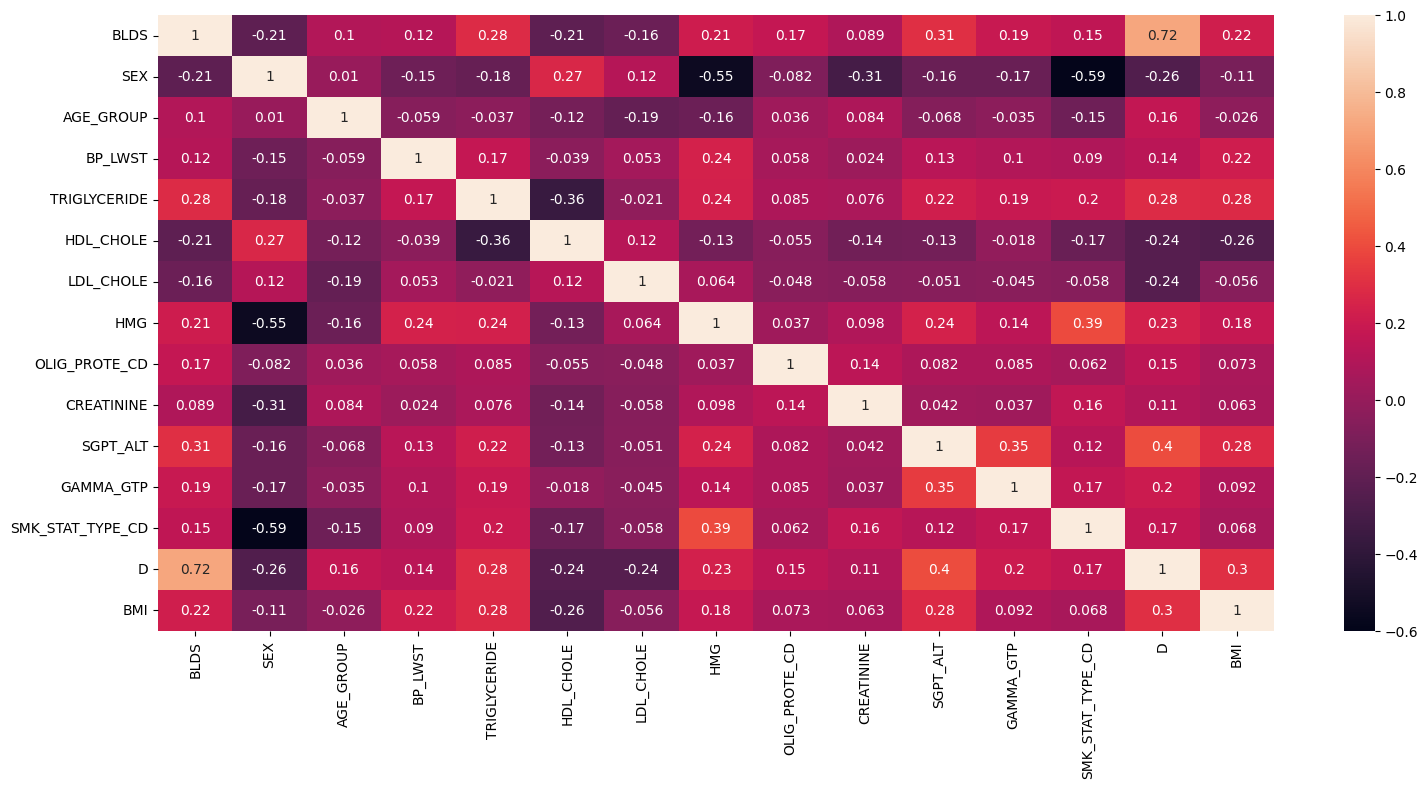

In [19]:
# sns.heatmap(train[['WEIGHT', 'BLDS']].corr())
# plt.scatter(train['WEIGHT'], train['BLDS'], s=3)
# plt.show()
plt.figure(figsize=(18, 8))
corr = origin_df.corr()
# print(corr)
sns.heatmap(corr, annot=True, square=False, vmin=-0.6, vmax=1.0)

In [22]:
origin_df.head()

,BLDS,SEX,AGE_GROUP,BP_LWST,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,D,BMI
0,126.0,1,11,65.0,158.0,44.0,147.0,14.0,1.0,0.0,19.0,17.0,2.0,1,31.020408
1,117.0,2,17,72.0,235.0,39.0,76.0,12.0,1.0,1.0,16.0,25.0,1.0,0,31.217482
2,84.0,2,9,83.0,260.0,67.0,107.0,13.0,1.0,0.0,17.0,15.0,1.0,0,18.730489
3,90.0,1,11,70.0,198.0,41.0,137.0,14.0,1.0,0.0,17.0,20.0,3.0,0,27.681661
4,218.0,2,9,82.0,157.0,45.0,129.0,12.0,1.0,0.0,9.0,22.0,1.0,1,33.203125


In [20]:
origin_df.to_csv("./data/train_df.csv")
val_df.to_csv("./data/validation_df.csv")
test_df.to_csv("./data/test_df.csv")